Programming Exercise3: Muti-class classification and Neural networks

In [29]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import random # to pick random images to display
import scipy.io # used to load the OCTAVE *.mat files
import matplotlib.cm as cm # used to display images in a specific colormap
from scipy.special import expit # vectorized sigmoid function
from PIL import Image # used to show matirx as an image


1 Multi-class Classification

1.1 Dataset

In [17]:
datafile = 'ex3data1.mat'
# read data file => *.mat
mat = scipy.io.loadmat(datafile)
# print (mat)
X, Y = mat['X'], mat['y']
# print ('x:',X,'y:',Y)

# insert a column of 1's to x as usual
X = np.insert(X, 0, 1, axis=1)

print ("'y' shape: %s. Unique elements in y: %s" % (mat['y'].shape, np.unique(mat['y'])))
print ("'X' shape: %s. X[0] shape: %s" % (X.shape,X[0].shape))
#X is 5000 images. Each image is a row. Each image has 400 pixels unrolled (20x20)
#y is a classification for each image. 1-10, where "10" is the handwritten "0"


'y' shape: (5000, 1). Unique elements in y: [ 1  2  3  4  5  6  7  8  9 10]
'X' shape: (5000, 401). X[0] shape: (401,)


1.2 Visualing the data

In [27]:
def getDatumImg(row):
    """
    function that is handed a single np array with 
    shape 1x400(the 20 by 20 grid of pixels is “unrolled” into a 400-dimensional vector.)
    creates an image object from it, and returns it
    """
    width, height = 20, 20
    square = row[1:].reshape(width, height)
    return square.T
    
def displayData(indices_to_display = None):
    """
    function that picks 100 random rows from X,
    creates a 20x20 image from each,
    then stitches缝合 them together into a 10x10 grid of image,
    and shows it
    """
    width, height = 20, 20
    nrows, ncols = 10, 10
    
    if not indices_to_display:
        #                    random.sample(seq, n)从seq中选择n个随机且独立的元素
        indices_to_display = random.sample(range(X.shape[0]), nrows*ncols)
    
    # 生成一个【20*10，20*10】矩阵
    big_picture = np.zeros((height*nrows, width*ncols))
    
    irow, icol = 0, 0
    for idx in indices_to_display:
        if icol == ncols:
            irow += 1
            icol =  0
        iimg = getDatumImg(X[idx])
        big_picture[irow*height:irow*height+iimg.shape[0], icol*width:icol*width+iimg.shape[1]] = iimg
        icol += 1
    
    fig = plt.figure(figsize=(6,6))
    img = Image.fromarray(big_picture)
    plt.imshow(img, cmap=cm.Greys_r)

    

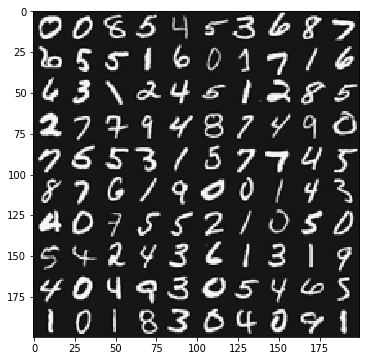

In [28]:
displayData()

1.3 Vectorizing logistic regression

In [31]:
# hypothesis function and cost function for logistic regression
def h(mytheta, myX):
    return expit(np.dot(myX, mytheta))

# a more simply written cost function
def computeCost(mytheta, myX, myY, myLambda=0):
    m = myX.shape[0] # 5000
    myH = h(mytheta, myX) # shape:(5000, 1)
    term1 = np.log(myH).dot(-myY.T) # shape:(5000,5000)
    term2 = np.log(1.0-myY).dot(1-myY.T) # shape:(5000,5000)
    left_hand = (term1 - term2)/m # shape:(5000,5000)
    right_hand = mytheta.T.dot(mytheta) * myLambda / (2*m) # shape:(1,1)
    return left_hand + right_hand # shape:(5000,5000)


1.4 One-vs-all Classification

In [36]:
# An alternative to OCTAVE's 'fmincg' we'll use some scipy.optimize function, "fmin_cg"
# This is more efficient with large number of parameters.
# In the previous homework, I didn't have to compute the cost gradient because
# the scipy.optimize function did it for me with some kind of interpolation...
# However, fmin_cg needs the gradient handed do it, so I'll implement that here
def costGradient(mytheta, myX, myY, myLambda=0.):
    m = myX.shape[0]
    # transpose y here because it makes the units work outin dot products later
    # 在此计算了hø(x)-y值
    beta = h(mytheta, myX)-myY.T # shape:(5000,5000)

    # regularization skips the first element is theta
    regterm = mytheta[1:]*(myLambda/m) # shape:(400,1)
    
    grad = (1./m)*np.dot(myX.T, beta) # shape:(401,5000)
    # regularization skps the first element in theta
    grad[1:] = grad[1:] + regterm
    return grad # shape:(401,5000)



In [37]:
from scipy import optimize

def optimizeTheta(mytheta, myX, myY, myLambda=0.):
    result = optimize.fmin_cg(computeCost, fprime=costGradient, x0=mytheta, \
                              args=(myX, myY, myLambda), maxiter=50, disp=False, \
                              full_output=True)
    return result[0], result[1]
        
    

In [47]:
def buildTheta():
    """
    function that determins an optimized theta for each class
    and returns a Theta function where each row corresponds to
    the learned logistic regression params for one class
    """
    
    mylambda = 0.
    initial_theta = np.zeros((X.shape[1], 1)).reshape(-1)
    Theta = np.zeros((10, X.shape[1]))
    for i in range(10):
        iclass = i if i else 10 # class "10" coresponds to handwritten zero
        # print ("Optimizing for handwritten number %d..."%i)
        logic_Y = np.array([1 if x == iclass else 0 for x in Y]) #.reshape((X.shape[0],1))
        iTheta, imincost = optimizeTheta(initial_theta, X, logic_Y, mylambda)
        Theta[i, :] = iTheta
#     print (Theta)
    print ("DONE!")
    return Theta
    

In [48]:
Theta = buildTheta()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while w

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while w

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while w

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while w

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while w

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while w

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while w

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while w

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while w

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while w

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while w

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while w

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while w

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while w

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while w

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while w

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while w

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while w

[[-6.85859812e+00  0.00000000e+00  0.00000000e+00 ... -3.49336479e-04
   1.50484553e-05  0.00000000e+00]
 [-3.85184542e+00  0.00000000e+00  0.00000000e+00 ...  5.37140004e-03
   5.00821411e-07  0.00000000e+00]
 [-3.03388848e+00  0.00000000e+00  0.00000000e+00 ...  2.86368770e-03
  -3.26363163e-04  0.00000000e+00]
 ...
 [-2.07663383e+00  0.00000000e+00  0.00000000e+00 ... -9.38264529e-04
   1.15487281e-04  0.00000000e+00]
 [-7.92858148e+00  0.00000000e+00  0.00000000e+00 ... -1.23777410e-04
   1.06541502e-05  0.00000000e+00]
 [-4.29279146e+00  0.00000000e+00  0.00000000e+00 ... -3.10715213e-04
   1.77850613e-05  0.00000000e+00]]
DONE!


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while w

In [111]:
def predictOneVsAll(myTheta, myRow):
    """
    function that computes a hypothesis for an individual image (row in X)
    and returns are predicted integer corresponding to the handwritten image
    """
    classes = range(1, 11)
    hypots = [0] * len(classes)
    
    # compute a hypothesis for each possible outcome
    # choose the maximun hypothesis to find result
    for i in range(len(classes)):
        hypots[i] = h(myTheta[i], myRow)
    return classes[np.argmax(np.array(hypots))]
    

In [112]:
# rg = range(10,0,-1)
# print (len(rg), rg)

10 range(10, 0, -1)


In [114]:
# You should see that the training set accuarcy is about 94.9%
n_correct, n_total = 0., 0.
incorrect_indices = []

for irow in range(X.shape[0]):
    n_total += 1
    if predictOneVsAll(Theta, X[irow]) == Y[irow]:
        n_correct += 1
    else :
        incorrect_indices.append(irow)
print ("Training set accuracy: %0.1f%%"%(100*(n_correct/n_total)))   
    

Training set accuracy: 0.5%


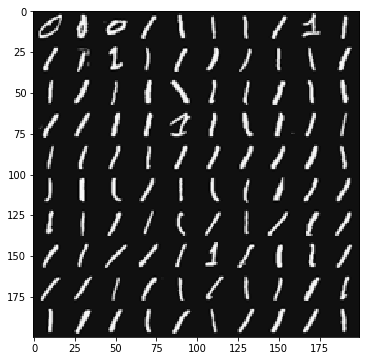

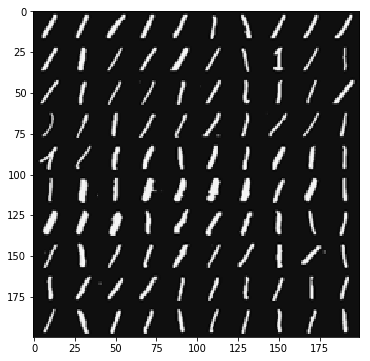

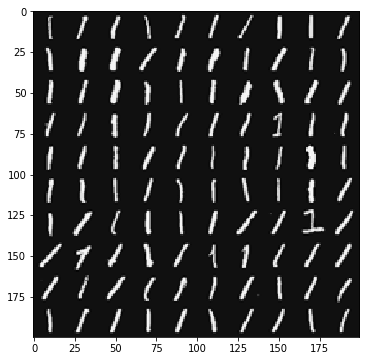

In [67]:
#Let's have a look at the ones we get wrong:
displayData(incorrect_indices[:100])
displayData(incorrect_indices[100:200])
displayData(incorrect_indices[200:300])

2 Neural Networks

2.1 Model representation

In [71]:
#You have been provided with a set of network parameters (Θ(1),Θ(2)) 
#already trained by us. These are stored in ex3weights.mat
datafile = 'ex3weights.mat'
mat = scipy.io.loadmat(datafile)
Theta1, Theta2 = mat['Theta1'], mat['Theta2']
print ("Theta1 has shape:",Theta1.shape)
print ("Theta2 has shape:",Theta2.shape)


Theta1 has shape: (25, 401)
Theta2 has shape: (10, 26)


2.2 Feedforward Propagation

In [78]:
def propagateForward(row, Thetas):
    """
    function that given a list of Thetas, propagates the
    row of feature forwards, assuming the features already
    include the bias unit in the input layer, and the
    Thetas need the bias unit added to features between each layer
    """
    features = row
    for i in range(len(Thetas)):
        Theta = Thetas[i]
        z = Theta.dot(features)
        a = expit(z)
        
        # end index theta -> return
        if i == len(Thetas) - 1:
            return a
        
        a = np.insert(a, 0, 1) # add the bias unit
        features = a
    

In [109]:
def predictNN(row, Thetas):
    """
    function that takes a row of features, propagates them through
    the NN, and returns the predicted integer that was handwritten
    """
    classes = range(1, 11)
    output = propagateForward(row, Thetas)
    
#     print (output)
#     print (np.argmax(np.array(output)))
#     print (classes[np.argmax(np.array(output))])
    
    return classes[np.argmax(np.array(output))]
    

In [116]:
# "You should see that the accuracy is about 97.5%"
myThetas = [Theta1, Theta2]
n_correct, n_total = 0., 0.
incorrect_indices = []

# loop over all of the rows in X (all of the handwritten images)
# and predict what digit is written. Check if it's correct, and 
# compute an efficiency
for irow in range (X.shape[0]):
    n_total += 1
    if predictNN(X[irow], myThetas) == int(Y[irow]):
        n_correct += 1
    else :
        incorrect_indices.append(irow)

# print (n_correct)
print ("Training set accuracy: %0.1f%%"%(100*(n_correct/n_total)))


Training set accuracy: 97.5%


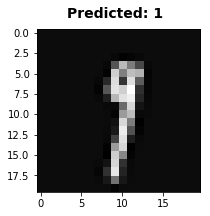

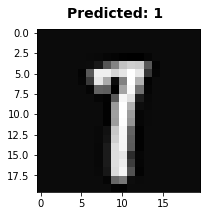

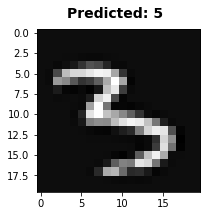

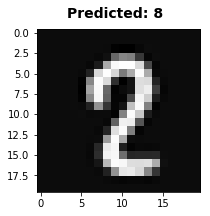

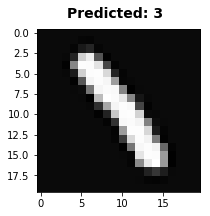

In [117]:
# pick some of the images we got WRONG and look at them
for x in range(5):
    i = random.choice(incorrect_indices)
    fig = plt.figure(figsize=(3,3))
    img = Image.fromarray(getDatumImg(X[i]))
    plt.imshow(img, cmap=cm.Greys_r)
    
    predicted_val = predictNN(X[i], myThetas)
    predicted_val = 0 if predicted_val == 10 else predicted_val
    fig.suptitle('Predicted: %d'%predicted_val, fontsize=14, fontweight='bold')
    